In [75]:
from qiskit_optimization.applications import Maxcut, Tsp
import matplotlib.pyplot as plt
import networkx as nx
import pennylane as qml
from pennylane import numpy as np
from pennylane import qaoa
from functools import partial

In [76]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

distance
 [[ 0. 48. 91.]
 [48.  0. 63.]
 [91. 63.  0.]]


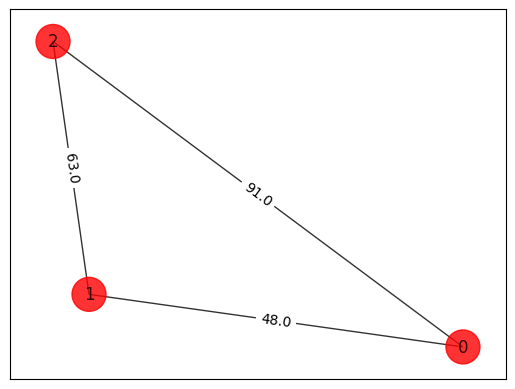

In [77]:
# Generating a graph of 3 nodes
n = 3
num_qubits = n*2
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

In [78]:
G2 = nx.DiGraph()
G2.add_nodes_from(tsp.graph)

for i in range(n):
    for j in range(n):
        if i != j:
            G2.add_edge(i, j, weight=adj_matrix[i, j])

In [79]:
cost_h, mixer_h, mapping  = qaoa.max_weight_cycle(G2)

print("cost_h\n", cost_h)
print("mixer_h\n", mixer_h)
print("mapping\n", mapping)

cost_h
   (3.871201010907891) [Z0]
+ (3.871201010907891) [Z2]
+ (4.143134726391533) [Z3]
+ (4.143134726391533) [Z5]
+ (4.51085950651685) [Z1]
+ (4.51085950651685) [Z4]
mixer_h
   (-0.25) [X0 Y1 Y5]
+ (-0.25) [X1 Y0 Y3]
+ (-0.25) [X2 Y3 Y4]
+ (-0.25) [X3 Y2 Y1]
+ (-0.25) [X4 Y5 Y2]
+ (-0.25) [X5 Y4 Y0]
+ (0.25) [X0 X1 X5]
+ (0.25) [Y0 Y1 X5]
+ (0.25) [Y0 X1 Y5]
+ (0.25) [X1 X0 X3]
+ (0.25) [Y1 Y0 X3]
+ (0.25) [Y1 X0 Y3]
+ (0.25) [X2 X3 X4]
+ (0.25) [Y2 Y3 X4]
+ (0.25) [Y2 X3 Y4]
+ (0.25) [X3 X2 X1]
+ (0.25) [Y3 Y2 X1]
+ (0.25) [Y3 X2 Y1]
+ (0.25) [X4 X5 X2]
+ (0.25) [Y4 Y5 X2]
+ (0.25) [Y4 X5 Y2]
+ (0.25) [X5 X4 X0]
+ (0.25) [Y5 Y4 X0]
+ (0.25) [Y5 X4 Y0]
mapping
 {0: (0, 1), 1: (0, 2), 2: (1, 0), 3: (1, 2), 4: (2, 0), 5: (2, 1)}


6
Cost after step 1: 2.35984474700382
Cost after step 2: -4.398568632879477
Cost after step 3: -4.7904562528318735
Cost after step 4: -4.778138421652334
Cost after step 5: -1.7411850318447142
Cost after step 6: 2.838869823270377
Cost after step 7: 2.4792777316936756
Cost after step 8: -3.8978346046988124
Cost after step 9: 1.05288749400086
Cost after step 10: 1.0010736901822128
Cost after step 11: -1.2833564625969756
Cost after step 12: -1.9435652000070145
Cost after step 13: 1.8728294973643813
Cost after step 14: -0.05985018019188526
Cost after step 15: -4.160219267349681
Cost after step 16: 1.0374212206770732
Cost after step 17: -0.979739024419201
Cost after step 18: -2.1940819933507676
Cost after step 19: -4.495804118366474
Cost after step 20: -3.298879792127297
Cost after step 21: 2.5407319985562378
Cost after step 22: -3.246068374856616
Cost after step 23: 0.48970365789688897
Cost after step 24: 2.788997035567721
Cost after step 25: 2.5643031851411604
Cost after step 26: -0.589083

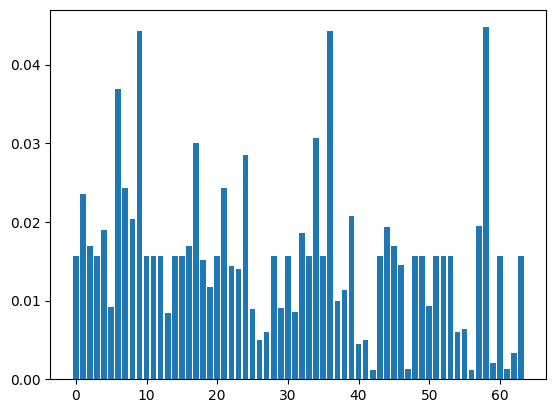

In [82]:

def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

print(num_qubits)
wires = range(num_qubits)
depth = 2

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

dev = qml.device("default.qubit", wires=wires)

#@partial(qml.cut_circuit, auto_cutter=True) 
@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

optimizer = qml.GradientDescentOptimizer()
steps = 70
params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

for i in range(steps):
    params = optimizer.step(cost_function, params)
    print(f"Cost after step {i + 1}: {cost_function(params)}")

print("Optimal Parameters")
print(params)


@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

probs = probability_circuit(params[0], params[1])

# bitstrings
bitstrings = [format(i, "0" + str(len(wires)) + "b") for i in range(2 ** len(wires))]

plt.bar(range(2**len(wires)), probs)
plt.show()

In [83]:
print(mapping)

# get most likely bitstring (5 most likely)
most_likely = np.argsort(probs)[:-10:-1]

for i in most_likely:
    print(bitstrings[i], "with probability", probs[i])



{0: (0, 1), 1: (0, 2), 2: (1, 0), 3: (1, 2), 4: (2, 0), 5: (2, 1)}
111010 with probability 0.0447508157789394
100100 with probability 0.04422545359709219
001001 with probability 0.04422545359709219
000110 with probability 0.036898660019320934
100010 with probability 0.030696677890689066
010001 with probability 0.030023836901228736
011000 with probability 0.028572368196818448
000111 with probability 0.024293928870909486
010101 with probability 0.024293928870909462
